In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

%reload_ext spaudiopy
import spaudiopy as spa

In [2]:
# Publication stuff
default_figsize = (3.39, 3.0)
plt.rcParams['figure.figsize'] = default_figsize
font = {'family' : 'serif',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['axes.titlesize'] = 9

First, define sectors uniformly covering the sphere.

In [3]:
# CHOOSE HERE:
N_sph_sec = 2  # sector order
ENREC = False  # amplitude or energy reconstruction
pattern = "maxRE"

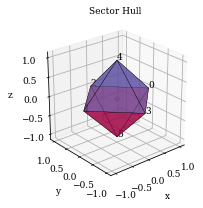

In [4]:
# steering of sectors
sec_vecs = spa.grids.load_t_design(2*N_sph_sec if ENREC else N_sph_sec+1)  # N+1 or 2N
sec_azi, sec_colat, _ = spa.utils.cart2sph(*sec_vecs.T)
# number of sectors
J_sec = len(sec_vecs)

fig = plt.figure()
spa.plots.hull(spa.decoder.get_hull(*sec_vecs.T), title="Sector Hull", fig=fig)
plt.savefig('hull.pdf')

In [5]:
if pattern.lower() == "cardioid":
    c_n = spa.sph.cardioid_modal_weights(N_sph_sec)
elif pattern.lower() == "hypercardioid":
    c_n = spa.sph.hypercardioid_modal_weights(N_sph_sec)
elif pattern.lower() == "maxre":
    c_n = spa.sph.maxre_modal_weights(N_sph_sec, True)  # works with amplitude compensation and without!
else:
    assert()

w_sec_nm = spa.sph.repeat_per_order(c_n) * spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_colat, 'real')

In [6]:
def directivity_factor(f_nm):
    """Directivity of spatial filter in SH domain.
    (eq.33)[Politis, A., & Pulkki, V. (2016).
    Acoustic intensity, energy-density and diffuseness estimation in a directionally-constrained region.]
    """
    f_nm = spa.utils.asarray_1d(f_nm)
    return np.real_if_close((4*np.pi)/(f_nm.conj().T@f_nm))

def directivity_factor_fromc(c_n):
    """(eq. 5.30) Rafaely, B. (2015). Fundamentals of Spherical Array Processing. Springer."""
    c_n = spa.utils.asarray_1d(c_n)
    a = (np.sum(c_n * (2*np.arange(len(c_n))+1)/(4*np.pi)))**2
    b = 1/(4*np.pi) * np.sum(c_n**2 * (2*np.arange(len(c_n))+1)/(4*np.pi))
    return a/b

In [7]:
sector_q = directivity_factor(w_sec_nm[0, :])
print("Directivity:", sector_q)
spa.utils.test_diff(sector_q, directivity_factor_fromc(c_n), "from c:")  # amplitude sensitive, e.g. unnormalized maxrE

print("\nCompare to analytical:")
spa.utils.test_diff(sector_q, 2*N_sph_sec + 1, "Cardiods:")  # analytic for cardioids: (2N+1)
spa.utils.test_diff(sector_q, (N_sph_sec + 1)**2, "Hyper-Cardioids");  # analytic for PWD: (N+1)^2

Directivity: 7.865049492131579
from c: -- Close enough.

Compare to analytical:
Cardiods: -- Diff:  2.865049492131579
Hyper-Cardioids -- Diff:  1.134950507868421


Look at the first few sector patterns.

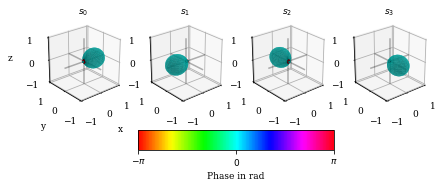

In [8]:
fig = plt.figure(figsize=(7, 3.3))
spa.plots.sh_coeffs_subplot([w_sec_nm[0, :], w_sec_nm[1, :],
                             w_sec_nm[2, :], w_sec_nm[3, :]],
                            titles=["$s_0$", "$s_1$", "$s_2$", "$s_3$"], 
                            fig=fig)
plt.savefig('sectors.pdf')

Next, testing the energy and amplitude preserving properties of sector patterns.
For that it's easier to go back to discrete domain, sum there, and then go back.

So, for amplitude

$
w0_{nm} = SHT[\sum_s^S \beta_a iSHT[ws_{nm}]]
$,

and energy

$
w0_{nm} = SHT[\sum_s^S \beta_e (|iSHT[ws_{nm}]|)^2]
$.

The factor $\beta$ ensures either amplitude or energy preservation.

In [9]:
# iSHT to discrete domain
trans_azi, trans_colat, _ = spa.utils.cart2sph(*spa.grids.load_t_design(2*N_sph_sec).T)
secs = spa.sph.inverse_sht(w_sec_nm.T, trans_azi, trans_colat, 'real')
sum_secs = np.sum(secs, axis=1)

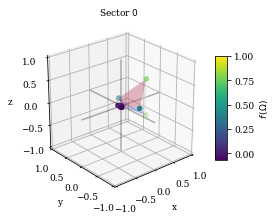

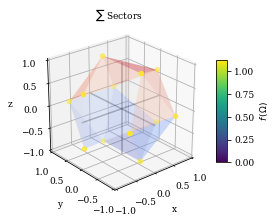

In [10]:
spa.plots.spherical_function(secs[:, 0], trans_azi, trans_colat, title='Sector $0$')
spa.plots.spherical_function(sum_secs, trans_azi, trans_colat, title=r'$\sum$ Sectors')

Beta_e -- Close enough.
Reconstruction 0 -- Close enough.


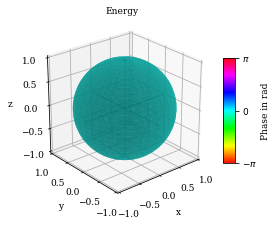

In [11]:
# energy beta factor
#beta_e = sector_q/J_sec
beta_e = 1/ (w_sec_nm[0, :].conj()@w_sec_nm[0, :]/np.sqrt(4*np.pi) * J_sec/np.sqrt(4*np.pi))
# test alternative
spa.utils.test_diff(beta_e, sector_q/J_sec, "Beta_e")

# Energy Reconstruction
w0_e = spa.sph.sht(beta_e*np.sum(abs(secs)**2, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
spa.utils.test_diff(w0_e[0], np.sqrt(4*np.pi), "Reconstruction 0")
spa.plots.sh_coeffs(w0_e, title="Energy")

Beta_a -- Close enough.
Beta_a = Beta_e -- Diff:  0.42505595014500497
Reconstruction 0 -- Close enough.


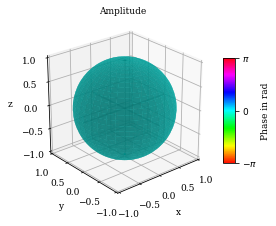

In [12]:
# amplitude beta factor
#beta_a = (N_sph_sec+1)/J_sec  # only cardioids
#beta_a = 1/ (w_sec_nm[0, 0]*np.sqrt(4*np.pi)/np.sqrt(4*np.pi) * J_sec/np.sqrt(4*np.pi))
beta_a = np.sqrt(4*np.pi)/ (w_sec_nm[0, 0] * J_sec)
# test alternative
spa.utils.test_diff(beta_a,  4*np.pi / (c_n[0] * J_sec), "Beta_a")
spa.utils.test_diff(beta_a, beta_e, "Beta_a = Beta_e")  # True for PWD!

# Amplitude Reconstruction
w0_a = spa.sph.sht(np.sum(beta_a*secs, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
spa.utils.test_diff(w0_a[0], np.sqrt(4*np.pi), "Reconstruction 0")
spa.plots.sh_coeffs(w0_a, title="Amplitude")

In [13]:
# Check full reconstruction
spa.utils.test_diff(np.sum(w0_a), np.sqrt(4*np.pi), "Amplitude reconstruction")
spa.utils.test_diff(np.sum(w0_e), np.sqrt(4*np.pi), "Energy reconstruction")
# ensured by not always up to 1, e.g. in case of grid higher 2N
print("sector max:", np.round(np.real_if_close(np.max(secs, axis=0)), 3))

Amplitude reconstruction -- Close enough.
Energy reconstruction -- Close enough.
sector max: [0.779 0.779 0.779 0.779 0.779 0.779]


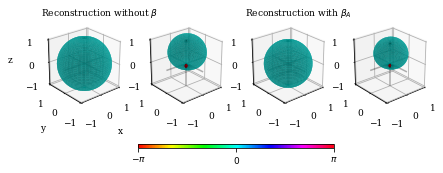

In [14]:
# Amplitude Reconstruction
w0_a_with = spa.sph.sht(np.sum(beta_a*secs, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
w0_a_without = spa.sph.sht(np.sum(1*secs, axis=1),
                   N_sph_sec, trans_azi, trans_colat, 'real')
w_part_without = spa.sph.sht(np.sum(secs[:, ::2], axis=1),
                     N_sph_sec, trans_azi, trans_colat, 'real')
w_part_with = spa.sph.sht(beta_a*np.sum(secs[:, ::2], axis=1),
                     N_sph_sec, trans_azi, trans_colat, 'real')

fig = plt.figure(figsize=(7, 3.))
spa.plots.sh_coeffs_subplot([w0_a_without, w_part_without, w0_a_with, w_part_with],
                            fig=fig, azi_steps=2, el_steps=2)
# custom stuff
cbar = fig.get_axes()[-1]
cbar.set_aspect(1/50)  # cbar
cbar.set_xlabel(None)  # little hack bc of horizontal cbar

fig.axes[0].set_title(r"Reconstruction without $\beta$", loc='left')
fig.axes[2].set_title(r"Reconstruction with $\beta_A$", loc='left')
plt.savefig('reconstruction_withandwithout.pdf')

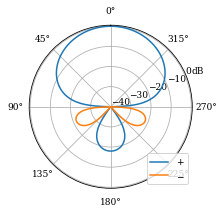

In [15]:
# cross section
cross_azi = np.linspace(0, 2 * np.pi, 720, endpoint=True)

# Bandlimited Dirac pulse
dirac_bandlim = spa.sph.bandlimited_dirac(N_sph_sec,cross_azi, c_n)

spa.plots.polar(cross_azi, dirac_bandlim)
plt.savefig('sectors_cross.pdf')

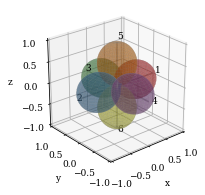

In [16]:
fig = plt.figure()
spa.plots.sh_coeffs_overlay([*w_sec_nm], fig=fig, azi_steps=2, el_steps=2)  # title="Sector Patterns"
# loudspeaker no
ax = plt.gca()
for s, co in enumerate(np.c_[spa.utils.sph2cart(sec_azi, sec_colat, 1.1)]):
    ax.text(co[0], co[1], co[2], s+1)
plt.savefig('sectors_overlay.pdf')

Evaluation
---
Looking at the reconstruction plots and test above, now looking at signal space.

- Numerical evaluation of $\beta_A$ by inverting amplitude reconstruction with pseudo inverse in discrete domain gives least squares solution

- RMS estimation using "unit amplitude" fields here, so that RMS of each component is one. Superposition of independent noise signals should result in $\sqrt{2}$.

In [17]:
print("Amp reconstruction error without, in dB: ", np.round(spa.utils.db(spa.utils.rms(sum_secs)), 3))
print("Amp reconstruction error with beta_A, in dB: ", np.round(spa.utils.db(spa.utils.rms(beta_a * sum_secs)), 3))
b_ls = np.linalg.pinv(secs) @ np.ones((secs.shape[0], 1))
spa.utils.test_diff(np.mean(b_ls), beta_a, "Least-squares mean and analytic beta_A:")

Amp reconstruction error without, in dB:  1.053
Amp reconstruction error with beta_A, in dB:  0.0
Least-squares mean and analytic beta_A: -- Close enough.


2.886579864025407e-15

In [18]:
# Evaluation
from numpy.random import default_rng
rng = default_rng()

fs = 48000
in_nm_diff = 1 * rng.standard_normal((3*fs, (N_sph_sec+1)**2))
in_nm_pw1 = 1 * rng.standard_normal((3*fs, 1)) * spa.sph.sh_matrix(N_sph_sec, sec_azi[0], sec_colat[0], 'real')
in_nm_pw2 = 1 * rng.standard_normal((3*fs, 1)) * spa.sph.sh_matrix(N_sph_sec, sec_azi[2], sec_colat[2], 'real')

in_nm = in_nm_diff + in_nm_pw1 + in_nm_pw2

In [19]:
def rms(X, axis=0):
    return np.sqrt(np.mean(np.square(np.abs(X)), axis=axis))

In [20]:
in_sec = in_nm @ w_sec_nm.T  # discrete domain
print(rms(in_nm))
print(rms(in_sec))

[1.07304892 1.11245685 0.99650818 1.11395901 1.0020073  1.0027288
 1.09476392 1.00077044 1.26641225]
[1.61151515 1.27027054 1.61208067 1.26686835 1.26377687 1.25843892]


In [21]:
p_rms_ref = rms(in_nm[:, 0])
print("REF:", p_rms_ref)
p_rms_without = (1/np.sqrt(4*np.pi) * rms(1 * np.sum(in_sec, axis=1)))
print("Without:", p_rms_without)
p_rms_with = (1/np.sqrt(4*np.pi) * rms(beta_a * np.sum(in_sec, axis=1)))
print("With:", p_rms_with)
spa.utils.test_diff(p_rms_ref, p_rms_with, "RMS compensation:");

REF: 1.0730489212342764
Without: 1.211409272116273
With: 1.073048927563078
RMS compensation: -- Close enough.


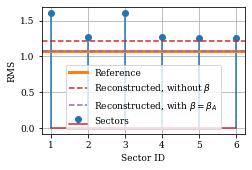

In [22]:
default_figsize = plt.rcParams.get('figure.figsize')
fig, ax = plt.subplots(figsize=(default_figsize[0], 3/4*default_figsize[1]), constrained_layout=True)
ax.stem(np.arange(in_sec.shape[1])+1,rms(in_sec), label='Sectors')

ax.axhline(p_rms_ref, color='C1', linewidth=3, label='Reference')
ax.axhline(p_rms_without, color='C3', linestyle='dashed', label=r'Reconstructed, without $\beta$')
ax.axhline(p_rms_with, color='C4', linestyle='dashed', label=r'Reconstructed, with $\beta=\beta_A$')

#plt.ylim([0., 1.5])
plt.xlabel('Sector ID')
plt.ylabel('RMS')
plt.legend()
plt.grid('on')
plt.savefig('evaluation.pdf')

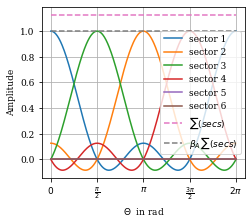

In [23]:
# 2nd order AP: 6 sectors in Cartesian axis
if J_sec == 6:
    delta_omega = np.linspace(0, 2*np.pi, 360)

    # XY-plane
    s_delta = spa.utils.angle_between([1, 0, 0], sec_vecs[:4, :])
    s_dir = np.dot(np.cross([1, 0, 0], sec_vecs[:4, :]), np.r_[0, 0, 1])
    s_delta[abs(s_dir)>0] = s_delta[abs(s_dir)>0] * np.sign(s_dir[abs(s_dir)>0])

    omega_d = np.tile(delta_omega, (4, 1)) - s_delta[:, np.newaxis]

    # Z axis
    omega_d = np.vstack((omega_d, np.pi/2 * np.ones((2, 360))))

    s = np.zeros((6, 360))
    for idx, delta_iter in enumerate(omega_d):
        s[idx, :] = spa.sph.bandlimited_dirac(2, delta_iter, 
                                              spa.sph.maxre_modal_weights(2, UNITAMP=True))

    fig = plt.figure(constrained_layout=True)
    for idx in range(6):
        plt.plot(delta_omega, s[idx, :], label="sector " + str(idx+1))
    plt.plot(delta_omega, np.sum(s, 0), '--', label=r"$\sum(secs)$")
    plt.plot(delta_omega, beta_a * np.sum(s, 0), '--', label=r"$\beta_A\,\sum(secs)$")

    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
               ['$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

    plt.ylabel('Amplitude')
    plt.xlabel('$\Theta$  in rad')
    plt.legend()
    plt.grid('on')
    plt.savefig('filterbank.pdf')


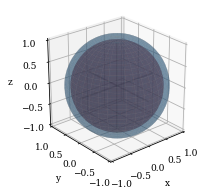

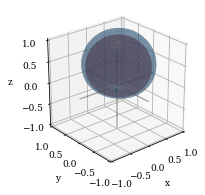

In [24]:
fig = plt.figure()
spa.plots.sh_coeffs_overlay([w0_a_with, w0_a_without], fig=fig)
fig = plt.figure()
spa.plots.sh_coeffs_overlay([w_part_with, w_part_without], fig=fig)